In [73]:
import dtw as r_dtw
import spft as spft
from os.path import join
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.stats import linregress
from scipy.stats import zscore
from tslearn.metrics import dtw, dtw_path
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [74]:
##
## Copyright (c) 2006-2019 of Toni Giorgino
##
## This file is part of the DTW package.
##
## DTW is free software: you can redistribute it and/or modify it
## under the terms of the GNU General Public License as published by
## the Free Software Foundation, either version 3 of the License, or
## (at your option) any later version.
##
## DTW is distributed in the hope that it will be useful, but WITHOUT
## ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
## or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public
## License for more details.
##
## You should have received a copy of the GNU General Public License
## along with DTW.  If not, see <http://www.gnu.org/licenses/>.
##

"""Warp one timeseries into the other"""

import numpy
import scipy.interpolate 


# Ties in x are removed and their y mean is used
def _solveTies(x,y):
    n = numpy.bincount(x)
    s = numpy.bincount(x,y)
    return numpy.arange(len(n)), s/n

# Should mimic R's stats::approx as closely as possible
def _interp(x, y):
    xt, yt = _solveTies(x,y)
    return scipy.interpolate.interp1d(xt, yt)
    

def warp2(d, index_reference=False):
    # IMPORT_RDOCSTRING warp
    """Apply a warping to a given timeseries
Returns the indexing required to apply the optimal warping curve to a
given timeseries (warps either into a query or into a reference).
**Details**
The warping is returned as a set of indices, which can be used to
subscript the timeseries to be warped (or rows in a matrix, if one wants
to warp a multivariate time series). In other words, ``warp`` converts
the warping curve, or its inverse, into a function in the explicit form.
Multiple indices that would be mapped to a single point are averaged,
with a warning. Gaps in the index sequence are filled by linear
interpolation.
Parameters
----------
d : 
    `dtw` object specifying the warping curve to apply
index_reference : 
    `True` to warp a reference, `False` to warp a query
Returns
-------
A list of indices to subscript the timeseries.
Examples
--------
>>> from dtw import *
>>> import numpy as np
Default test data
>>> (query, reference) = dtw_test_data.sin_cos()
>>> alignment = dtw(query,reference);
>>> wq = warp(alignment,index_reference=False)
>>> wt = warp(alignment,index_reference=True)
>>> import matplotlib.pyplot as plt;		# doctest: +SKIP
... plt.plot(reference);
... plt.plot(query[wq]); 
... plt.gca().set_title("Warping query")
>>> import matplotlib.pyplot as plt;		# doctest: +SKIP
... plt.plot(query);
... plt.plot(reference[wt]); 
... plt.gca().set_title("Warping reference")
Asymmetric step makes it "natural" to warp
the reference, because every query index has
exactly one image (q->t is a function)
>>> alignment = dtw(query,reference,step_pattern=asymmetric)
>>> wt = warp(alignment,index_reference=True);
>>> plt.plot(query, "b-")               	# doctest: +SKIP
... plt.plot(reference[wt], "ok", facecolors='none')
"""
    # ENDIMPORT
    if not index_reference:
        iset = d.index1
        jset = d.index2
    else:
        iset = d.index2
        jset = d.index1

    jmax = numpy.max(jset)

    # Scipy interp1d is buggy. it does not deal with leading
    # duplicated values of x. It returns different values
    # depending on the dtypes of arguments.
    ifun = _interp(x=jset, y=iset)
    ii = ifun(numpy.arange(jmax+1))

    # Quick fix for bug
    if numpy.isnan(ii[0]):
        ii[numpy.isnan(ii)] = iset[0]
    return ii.astype(int)

161.5957562775184


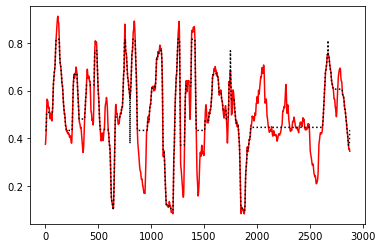

In [78]:
##assymetric looks great, but we need to compute the dtw with with the reference as the query and the force as the reference
tw = r_dtw.dtw(t_ref,t_for, keep_internals=True, step_pattern='symmetric2') #we treat the reference as the query and the force as the target, such that we can apply the warp afterwards
print(tw.distance)
warp_r = warp2(tw,index_reference=True) #then we compute the warp for the "reference" (which is actually the for), so that we can apply the warp to the force to get it into the reference space
plt.figure()
plt.plot(t_ref,'r')
plt.plot(t_for[warp_r],'k:')


In [4]:
in_dir = './testing/2022_06_test_right_only'
subs = ['Derek','Isa','Jhelum_L','Kimia','Mika']
sub=subs[0]
# for idx,sub in enumerate(subs):
print(sub)
data = spft.load_yaml(join(in_dir,f'LAB_{sub}_Test_Right_Only_out-file.txt'))
res = spft.score_spft_data(data)
    # if idx == 0:
    #     all_LRN_lag = np.zeros((len(subs),LRN_lag.shape[0]))
    # all_LRN_lag[idx,:] = LRN_lag

Derek


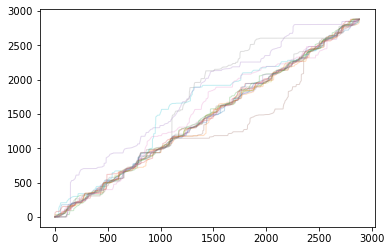

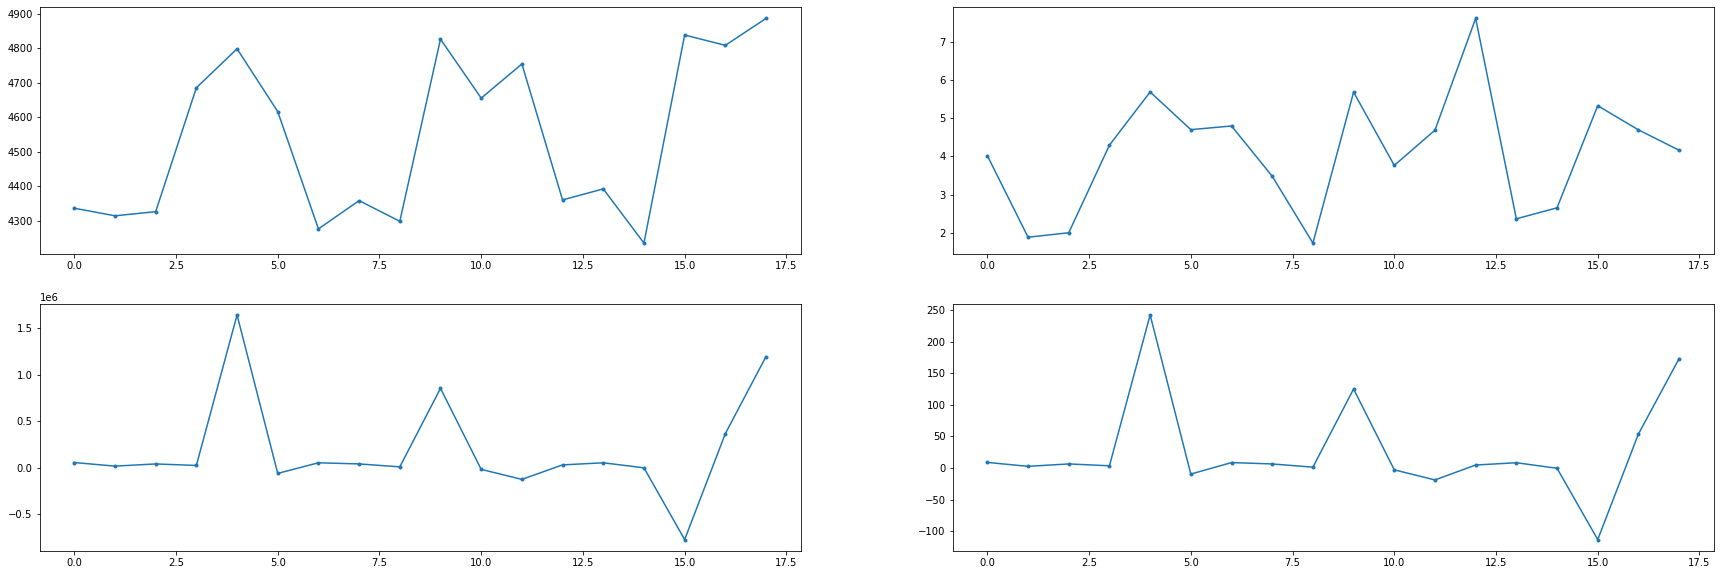

In [146]:
def get_dist_2_diag(t_ref, path):
    diag_len = t_ref.shape[0] #lengths are the same, so we just use one
    diag_coord = np.arange(0,diag_len)
    diag_coords = np.vstack([diag_coord,diag_coord]).T #now represents diagonal
    dist_2_diag = []
    # _path = np.array(path)
    for el in path:
        # print(el)
        _sub_mat = diag_coords - el
        _sub_mat_sign = np.sign(_sub_mat[:,1]) # sign based on y-axis, tells us which direction in time we warped
        _eucl_dist = np.sqrt(((_sub_mat)**2).sum(axis=1))
        _min_idx = np.argmin(_eucl_dist)
        dist_2_diag.append(_eucl_dist[_min_idx]*_sub_mat_sign[_min_idx])
    return np.mean(dist_2_diag)

trial_idx = 0
path_len = []
path_dist = []
path_diff_from_diag_xmy = [] #path difference from x=y, in reference to x (i.e., reported as x-y)
path_dist_2_diag = []
## TODO: path difference from diagonal as EUCLIDEAN distance
for trial_idx in np.arange(0,18):
    t_ref = res['trial_data']['ref_interp'][trial_idx] #trial ref and force values, in same timespace
    t_for = res['trial_data']['for_interp'][trial_idx]

    path, score = dtw_path(t_ref,t_for) #we treat the reference as the query and the force as the target, such that we can apply the warp afterwards
    # print(len(path), end=', ')
    path_diff_from_diag_xmy.append(-1*np.diff(np.array(path),axis=1)) # this is the deviation from the diagonal, kind of
    path_len.append(len(path))
    path_dist.append(score)
    dist_2_diag = get_dist_2_diag(t_ref,path)
    path_dist_2_diag.append(dist_2_diag)
    # print(linregress(path).slope)
    plt.plot([j for (i, j) in path], [i for (i, j) in path], "-",
                linewidth=1.,alpha=.25)

path_diff_from_diag_xmy_sum = [np.sum(x) for x in path_diff_from_diag_xmy]
path_len = np.array(path_len)
path_dist = np.array(path_dist)
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
plt.plot(path_len,'.-')
plt.subplot(2,2,2)
plt.plot(path_dist,'.-')
plt.subplot(2,2,3)
plt.plot(path_diff_from_diag_xmy_sum,'.-')
plt.subplot(2,2,4)
plt.plot(path_dist_2_diag,'.-')

In [145]:
path_dist_2_diag

[5.0,
 3.605551275463989,
 6.4031242374328485,
 -2.23606797749979,
 252.43811122728675,
 -9.219544457292887,
 9.899494936611665,
 5.0,
 2.8284271247461903,
 70.71067811865476,
 -5.656854249492381,
 -14.866068747318506,
 2.8284271247461903,
 5.0,
 -1.4142135623730951,
 -35.35533905932738,
 24.041630560342615,
 82.73451516749222]

(2127, 1456)


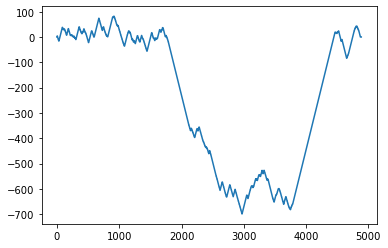

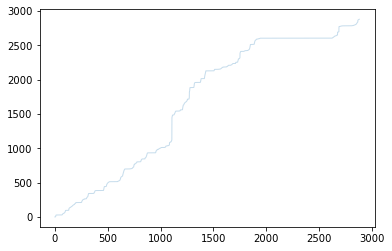

In [88]:
plt.plot(np.diff(np.array(path),axis=1))
print(path[3000])
plt.figure()
plt.plot([j for (i, j) in path], [i for (i, j) in path], "-",
            linewidth=1.,alpha=.25)

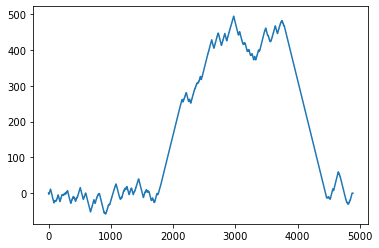

In [137]:
plt.plot(dist_2_diag)

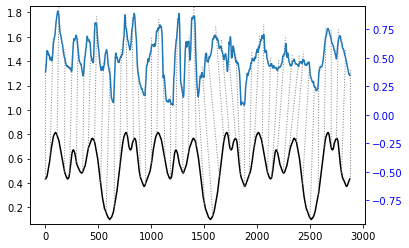

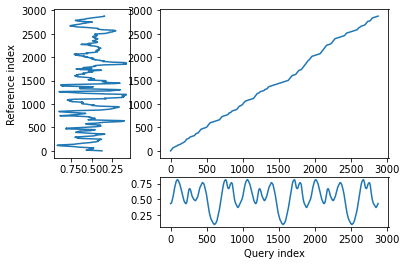

distance: 690.11


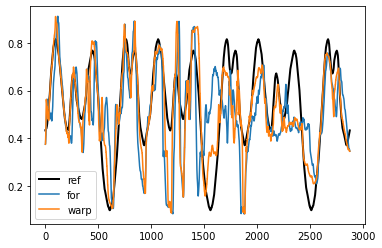

In [104]:
trial_idx =17
t_ref = res['trial_data']['ref_interp'][trial_idx] #trial ref and force values, in same timespace
t_for = res['trial_data']['for_interp'][trial_idx]

tw = r_dtw.dtw(t_ref,t_for, keep_internals=True, step_pattern='mori2006') #we treat the reference as the query and the force as the target, such that we can apply the warp afterwards
warp_for2ref = warp2(tw,index_reference=True) #then we compute the warp for the "reference" (which is actually the for), so that we can apply the warp to the force to get it into the reference space

# tw = dtw(t_for, t_ref, keep_internals=True,step_pattern=rabinerJuangStepPattern(6, "c"))
# tw = dtw(t_for, t_ref, keep_internals=True, step_pattern='asymmetric')
tw.plot(type="twoway",offset=1)
tw.plot(type="threeway")
    # plt.plot(t_ref)
    # plt.plot(t_for)
print("distance: {:.2f}".format(tw.distance))
# rmse = np.sqrt(np.mean((t_ref-t_for[warp_for2ref])**2))
# print("rmse:   {.2f}".format(rmse))
plt.figure()
plt.plot(t_ref,'k',linewidth=2.,label='ref')
plt.plot(t_for,label='for')
plt.plot(t_for[warp_for2ref],label='warp')
plt.legend()
# plt.figure()
# plt.spy(tw.directionMatrix)

57.521148803988545
54.249092649693885

122.50597145848889
223.1486501317824


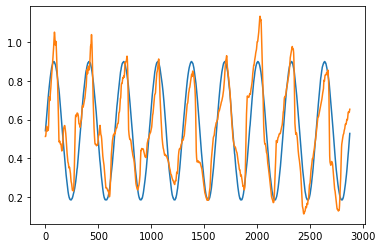

In [26]:
print(dtw(t_for,t_ref).distance)
print(fastdtw(t_for,t_ref,dist=euclidean)[0])
print("")
print(dtw((t_for)/t_for.max(),(t_ref)/t_ref.max()).distance)
print(fastdtw((t_for)/t_for.max(),(t_ref)/t_ref.max(),dist=euclidean)[0])

plt.plot((t_ref),label='ref')
plt.plot((t_for),label='for')

In [2]:
dist, path = fastdtw((t_for)/t_for.max(),(t_ref)/t_ref.max(),dist=euclidean)

NameError: name 't_for' is not defined

In [33]:
len(path)

4514

337.6370805332661
(2880,)
(2880,)
493.159738538251
498.9801855360977


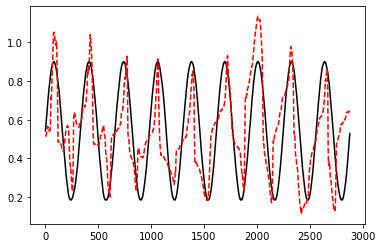

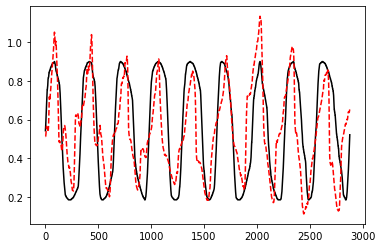

In [107]:
##assymetric looks great, but we need to compute the dtw with with the reference as the query and the force as the reference
tw = dtw(t_ref,t_for, keep_internals=True, step_pattern='mori2006') #we treat the reference as the query and the force as the target, such that we can apply the warp afterwards
print(tw.distance)
warp_2r = warp2(tw,index_reference=True) #then we compute the warp for the "reference" (which is actually the for), so that we can apply the warp to the force to get it into the reference space
warp_r2 = warp2(tw,index_reference=False) #then we compute the warp for the "reference" (which is actually the for), so that we can apply the warp to the force to get it into the reference space
print(warp_2r.shape)
print(warp_r2.shape)

plt.figure()
plt.plot(t_ref,'k')
plt.plot(t_for[warp_2r],'r--')

plt.figure()
plt.plot(t_ref[warp_r2],'k')
plt.plot(t_for,'r--')

print(np.sum(np.abs(t_ref-t_for[warp_2r])))
print(np.sum(np.abs(t_ref[warp_r2]-t_for)))

<module 'dtw.stepPattern' from '/opt/quarantine/miniforge/envs/py3p9/lib/python3.9/site-packages/dtw/stepPattern.py'>

82.62227842319834


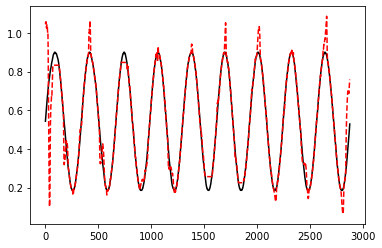

/opt/quarantine/miniforge/envs/py3p9/lib/python3.9/site-packages/dtw/warp.py:30: RuntimeWarning: invalid value encountered in divide
  return numpy.arange(len(n)), s/n


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 2880

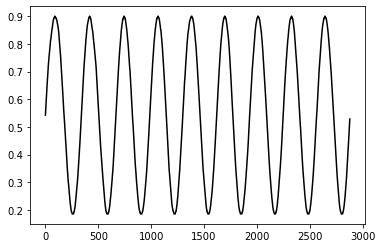

In [16]:
warp_q = warp(tw,index_reference=False) #query -> reference
warp_r = warp(tw,index_reference=True) #reference -> query
# plt.plot(t_for, 'r:',alpha=0.5)
plt.plot(t_ref,'k')
plt.plot(t_for[warp_q],'r') 

plt.figure()
plt.plot(t_for,'r')
plt.plot(t_ref[warp_r],'k')
